In [18]:
from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
import acoustic_entrainment
reload(brownian)
reload(time_series)
reload(acoustic_entrainment)
from acoustic_entrainment import VelocityResponse, muflown_response, muflown_sensitivity, mic_response
from time_series import find_files, find_ders, Collection, bin_func, TimeSeries
from brownian import abc_guess, get_krhoA, psd_func, logbin_func, get_sound_speed
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

from os import path

from matplotlib import rc
fontsize = 5
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    "text.latex.preamble":
        r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    "font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.4,
    'xtick.minor.width': 0.4,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.4,
    'ytick.minor.width': 0.4,
    "axes.linewidth": 0.4,
}
plt.rcParams.update(fontstyle)

# New function definitions

In [8]:
def sort_fnames(fnames, include=None, exclude=None):
    """
    Sort file names of the form <path>/iter_i by the iteration index i. 
    Include files with aspecific iteration index by passing a list to include. 
    """
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    if exclude is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr not in exclude]
    return fnames_sorted

from constants import kB
from scipy.integrate import cumulative_trapezoid

reload(brownian)
reload(acoustic_entrainment)
reload(time_series)
from acoustic_entrainment import VelocityResponse
from time_series import Collection
from brownian import get_params_from_abcRT, abc_guess, logbin_func, psd_func

def psd_calibration(fname, channel="X",
                   fmin=5e2, fmax=4e4, cutoff=1e6,  taumax=100e-3,freq_xnoise2=2e5,
                   plot=False, ax=None, logbin_Npts=20, color="k", data_plot_kwargs={}, fit_plot_kwargs={}):
    if plot:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(6,4))
        else:
            fig = plt.gcf()
        #axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)
    C = Collection(fname)
    C.set_collection(channel)
    C.apply("calibrate", cal=1/np.mean(C.PDF), inplace=True)
    Tavg = np.mean(C.T)
    if Tavg < 273.15:
        Tavg += 273.15
    Npts = int(C.r / (2*cutoff))
    C.apply("detrend", inplace=True, mode="constant")
    #C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=Npts, inplace=True)
    freq, psd = C.average("PSD", window="hamming", taumax=taumax)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    cal_params = get_params_from_abcRT(*abc, C.R, Tavg)
    C.params.update(cal_params)
    psd *= C.cal**2
    xnoise2 = np.mean(psd[freq>freq_xnoise2])
    C.xnoise2 = xnoise2
    if plot:
        plot_freq  = logbin_func(freq, Npts=logbin_Npts)
        plot_psd  = logbin_func(psd, Npts=logbin_Npts)
        dplot_kwargs = dict(mec=color, mfc="none", marker="o", ls="none")
        dplot_kwargs.update(data_plot_kwargs)
        ax.loglog(plot_freq, plot_psd, **dplot_kwargs)
        
        fplot_kwargs = dict(c=color)
        fplot_kwargs.update(data_plot_kwargs)
        ax.loglog(freq, psd_func(freq, C.k, C.rho, C.Tavg, C.R)+xnoise2, **fplot_kwargs)
        #ax.axhline(xnoise2)
        #ax.axvline(fmin, c="k", lw=1)
        #ax.axvline(fmax, c="k", lw=1)
        #axins.plot(freq, psd, c=color, marker=".", ls="none")
        #axins.set_xlim(500, 7000)
        #axins.set_ylim(0.9e-20, 5.1e-20)
        ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
        ax.set_xlabel(r"Frequency (Hz)")
        ax.set_xlim(right=cutoff)
        ax.set_ylim(bottom=1e-25)
        return C, ax
    return C

def cPSD(freq, psd, initial=None):
    if initial is None:
        initial = psd[0]*(freq[1]-freq[0])
    return cumulative_trapezoid(psd, x=freq, initial=initial)

def deg2rad(x):
    return x * np.pi / 180


def rad2deg(x):
    return x * 180 / np.pi

def radian_labels(ax, denoms=[-1, -2, 0, 2, 1], skip=1):
    rads = [np.pi/d if d!=0 else 0 for d in denoms]
    rad_labels = [r"$-\pi/%s$" % abs(d) if d<-1 \
             else r"$\pi/%s$" % abs(d) if d>1 \
             else "$-\pi$" if d == -1 \
             else "$\pi$" if d == 1 \
             else "$0$" for d in denoms]
    return rads, rad_labels
    

def dB_re(x, ref, typ):
    if typ == "pressure":
        deci = 20.
    elif typ == "power":
        deci = 10.
    return deci * np.log10(x/ref)

def db_re_inverse(x, ref, typ):
    if typ == "pressure":
        deci = 20.
    elif typ == "power":
        deci = 10.
    return ref * 10**(x/deci)


def SPL(x):
    return dB_re(x, ref=20e-6, typ="pressure")


def slope(x, m):
    return x/m

def line(x, speed, x0):
    return (x-x0)/speed

def slope_quad(x, a, b):
    return a*x + b*x*x

def powerlaw(x, a, m):
    return a * x**m

def exponential(x, a, m):
    return a * np.e**(x/m)

def find_pulse_points(time_series, tmin, tmax, factor=0.0, nozeros=False): 
    ts, xs = time_series.time_gate(tmin, tmax)
    # trough
    troughdex = np.argmin(xs)
    ttrough = ts[troughdex]
    xtrough = xs[troughdex]
    #peak
    peakdex = np.argmax(xs[ts<ttrough])
    tpeak = ts[ts<ttrough][peakdex]
    xpeak = xs[ts<ttrough][peakdex]
    if nozeros:
        tpoints = [0, tpeak, 0, ttrough, 0]
        xpoints = [0, xpeak, 0, xtrough, 0]
        return tpoints, xpoints
        
    # zeros
    pre_zerodex = np.where(np.diff(np.sign(xs-factor*xpeak)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    ## left
    peak_minus_zeros = tpeak - tzeros
    left_zeros_mask = peak_minus_zeros > 0
    left_zero = tzeros[left_zeros_mask][np.argmin(peak_minus_zeros[left_zeros_mask])]
    ## right
    pre_zerodex = np.where(np.diff(np.sign(xs-factor*xtrough)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    zeros_minus_trough = tzeros - ttrough
    right_zeros_mask =  zeros_minus_trough > 0
    right_zero = tzeros[right_zeros_mask][np.argmin(zeros_minus_trough[right_zeros_mask])]
    ## middle
    pre_zerodex = np.where(np.diff(np.sign(xs)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    mid_zero = tzeros[np.logical_and(tzeros>tpeak, tzeros<ttrough)][0]
    # important points
    tpoints = [left_zero, tpeak, mid_zero, ttrough, right_zero]
    xpoints = [factor*xpeak, xpeak, 0, xtrough, factor*xtrough]
    return tpoints, xpoints




def make_musphere_response(C0, impedance=None, r0=3e-2, response="bassetbound"):
    T = np.mean(C0.T)
    VR = VelocityResponse(1/C0.cal, C0.R, C0.rho, T, C0.cRH, C0.k)
    if impedance is None:
        _response = lambda f:VR.response(response, f)
    else:
        impedance = getattr(VR, f"{impedance}_impedance")
        _response = lambda f:VR.response(response, f)/impedance(f, r0)
    return _response

def load_collection(fname, channel, response, differentiate, 
                    cutoff=None, Npts="cutoff", shift=0, invert=False, 
                    window="boxcar", detrend="constant"):
    C = Collection(fname)
    C.set_collection(channel)
    if cutoff is not None:
        C.apply("lowpass", cutoff=cutoff, inplace=True)
    if Npts is not None:
        if Npts == "cutoff":
            if cutoff is not None:
                Npts=int(C.r/(2*cutoff))
            else:
                Npts = None
        C.apply("bin_average", Npts=Npts, inplace=True)
    if response is not None:
        C.apply("correct", response=response, n_jobs=1, 
            window=window, differentiate=differentiate, recollect=True)
    if response is None and differentiate:
        C.apply("differentiate", inplace=True)
        
    if detrend is not None:
        C.apply("detrend", mode=detrend, inplace=True)
    C.apply("shift", tau=shift, inplace=True)
    if invert:
        C.apply("calibrate", cal=-1, inplace=True)
    return C

# Directory structure

In [9]:
# Data by date
base_der = "/data/brownian"
date_ders = find_ders(base_der)
date_ders

['/data/brownian/20220707',
 '/data/brownian/20211215',
 '/data/brownian/20220720',
 '/data/brownian/20220330',
 '/data/brownian/20220518',
 '/data/brownian/20220525',
 '/data/brownian/20220614',
 '/data/brownian/20220628',
 '/data/brownian/20220715',
 '/data/brownian/20220523']

In [10]:
# Select a date
date_der_index = 2
bead_ders = find_ders(date_ders[date_der_index])
bead_ders

['/data/brownian/20220720/bead1']

In [11]:
# Select a date
bead_der_index = 0
experiment_ders = find_ders(bead_ders[bead_der_index])
experiment_ders

['/data/brownian/20220720/bead1/slow-phone_baseline',
 '/data/brownian/20220720/bead1/slow-phone_pos-scan-hi-res_1ms-delay_new-target',
 '/data/brownian/20220720/bead1/slow-phone_baseline3',
 '/data/brownian/20220720/bead1/slow-flown_baseline2',
 '/data/brownian/20220720/bead1/slow-flown_ene-pos-scan_1ms-delay',
 '/data/brownian/20220720/bead1/slow-phone_pos-scan-hi-res_1ms-delay',
 '/data/brownian/20220720/bead1/slow-phone_ene-pos-scan_1ms-delay',
 '/data/brownian/20220720/bead1/slow-phone_ene-scan-hi-res_1ms-delay']

# Bead calibration

In [12]:
baseline_experiment_index = [0, 3, 2]
baseline_fnames = find_files(experiment_ders[baseline_experiment_index[0]])
for experiment_der_index in baseline_experiment_index[1:]:
    next_fnames = find_files(experiment_ders[experiment_der_index])
    for fname in next_fnames:
        baseline_fnames.append(fname)

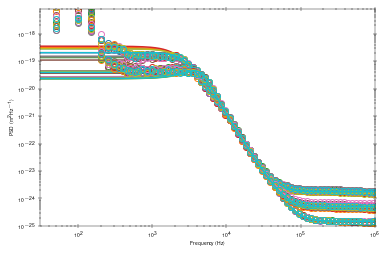

In [13]:
fmin = 2e3
fmax = 3e4
cutoff = 1000e3
taumax = 20e-3

fig, ax = plt.subplots(1,1, figsize=(6,4))

krhoCalTs = []
for fnamei, fname in enumerate(baseline_fnames):
    color = f"C{fnamei}"
    C0, ax = psd_calibration(fname, taumax=taumax, fmin=fmin, fmax=fmax, cutoff=cutoff, 
                             plot=True, ax=ax, color=color)
    krhoCalTs.append([C0.k, C0.rho, C0.cal, C0.Tavg, np.mean(C0.PDF), np.mean(C0.PDB)])    
krhoCalTs = np.array(krhoCalTs)

k : 13.567903912802352 5.175957768324882 38.148543810374214
rho : 1454.236280722401 55.309610837171675 3.8033441724955646
cal : 79.24412112289471 39.288276885181816 49.578790613693734
T : 23.744327418504934 0.10388128343756174 0.437499372404218
P : 150.0951931558204 0.42105849569494175 0.2805276350574548


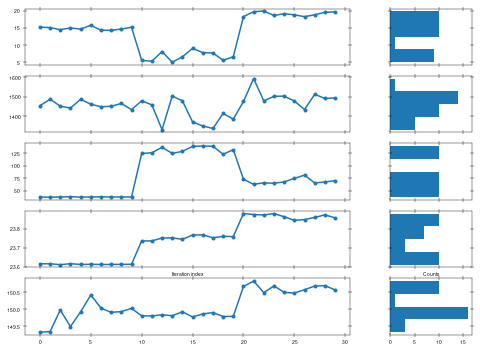

In [14]:
fig, axs = plt.subplots(5,2, figsize=(8, 6), gridspec_kw={"width_ratios":[0.8, 0.2]}, sharey="row", sharex="col")

ylabels = [r"$k~{\rm (fN \cdot nm^{-1})}$", r"$\rho~{\rm (g \cdot cm^{-3})}$", r"$A~{\rm (nm \cdot mV^{-1})}$", r"$T~{\rm (^{\circ}C)}$"]

for parami, param in enumerate(["k", "rho", "cal", "T", "P"]):
    vals = krhoCalTs[:, parami]
    # units
    if param == "k":
        vals = vals * 1e15 / 1e9
    if param =="cal":
        vals = vals * 1e9 / 1e3
    if param == "T":
        vals = vals -273.15
    if param == "P":
        vals =krhoCalTs[:, parami]+krhoCalTs[:, parami+1]
    
    # plot data
    axs[parami, 0].plot(vals, marker=".")
    axs[parami, 1].hist(vals, bins=4, orientation="horizontal")
    # labels
    #axs[parami, 0].set_ylabel(ylabels[parami])
    axs[3, 0].set_xlabel("Iteration index")
    axs[3, 1].set_xlabel("Counts")
    print(param, ":", np.mean(vals), np.std(vals), 100*np.std(vals)/np.mean(vals))
R = C0.R

In [55]:
C0.cal/=2

# Bandwidth selection

In [56]:
def pulse_params(time_series, tmin, tmax, factor=0.1): 
    ts, xs = time_series.time_gate(tmin, tmax)
    # trough
    troughdex = np.argmin(xs)
    ttrough = ts[troughdex]
    xtrough = xs[troughdex]
    
    #peak
    peakdex = np.argmax(xs[ts<ttrough])
    tpeak = ts[ts<ttrough][peakdex]
    xpeak = xs[ts<ttrough][peakdex]
   
        
    # Left
    left_10_90 = []
    for f in (factor, 1-factor):
        pre_zerodex = np.where(np.diff(np.sign(xs-f*xpeak)))[0]
        post_zerodex = 1 + pre_zerodex
        t1, t2 = ts[pre_zerodex], ts[post_zerodex]
        x1, x2 = xs[pre_zerodex], xs[post_zerodex]
        tzeros = t1 +(f*xpeak - x1)*((t2-t1)/(x2-x1))
        peak_minus_zeros = tpeak - tzeros
        left_zeros_mask = peak_minus_zeros > 0
        left_zero = tzeros[left_zeros_mask][np.argmin(peak_minus_zeros[left_zeros_mask])]
        left_10_90.append(left_zero)
    left_rise = left_10_90[1] - left_10_90[0]
    
    ## right
    right_10_90 = []
    for f in (factor, 1-factor):
        pre_zerodex = np.where(np.diff(np.sign(xs-f*xtrough)))[0]
        post_zerodex = 1 + pre_zerodex
        t1, t2 = ts[pre_zerodex], ts[post_zerodex]
        x1, x2 = xs[pre_zerodex], xs[post_zerodex]
        tzeros = t1 + (f*xtrough - x1)*((t2-t1)/(x2-x1))
        zeros_minus_trough = tzeros - ttrough
        right_zeros_mask =  zeros_minus_trough > 0
        right_zero = tzeros[right_zeros_mask][np.argmin(zeros_minus_trough[right_zeros_mask])]
        right_10_90.append(right_zero)
    right_rise = right_10_90[0] - right_10_90[1]
    
    
    ## middle
    pre_zerodex = np.where(np.diff(np.sign(xs)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    mid_zero = tzeros[np.logical_and(tzeros>tpeak, tzeros<ttrough)][0]
    
    left_duration = mid_zero - left_10_90[0]
    right_duration = right_10_90[0] - mid_zero
    

    timings = [left_rise, left_duration, right_rise, right_duration]
    peaks = [tpeak, xpeak, ttrough, xtrough]
    #plt.plot(ts, xs)
    #plt.scatter(tpeak, xpeak)
    #plt.scatter(left_10_90[0], factor*xpeak)
    #plt.scatter(left_10_90[1], (1-factor)*xpeak)
    #plt.scatter(ttrough, xtrough)
    #plt.scatter(right_10_90[0], factor*xtrough)
    #plt.scatter(right_10_90[1], (1-factor)*xtrough)
    #plt.show()
    return timings, peaks

# Slow phone position and energy scan

In [57]:
laser_delay = 1000e-6
pos0 = 4.4
c0 = get_sound_speed(T=C0.Tavg, RH=C0.cRH, p=C0.cP)

/data/brownian/20220720/bead1/slow-phone_ene-pos-scan_1ms-delay/iter_200.tdms


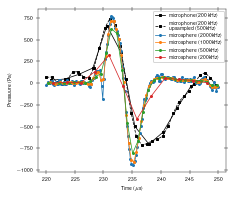

In [66]:
tmin= 220e-6
tmax = 250e-6
fig, ax = plt.subplots(1,1, figsize=(3.375, 3))

fname = sort_fnames(find_files(experiment_ders[6]))[200]
print(fname)
musphere_response = make_musphere_response(C0, response="bassetbound", impedance="plane")
Cph = load_collection(fname, "Y", mic_response, 
                          differentiate=False, cutoff=200e3, Npts="cutoff", shift=laser_delay+15e-6, invert=False)
Cph.aggrigate()
Cph.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us", zorder=0,
                marker="s", ms=2, c="k", lw=0.75, label=f"microphone (200 kHz)")

Cph = load_collection(fname, "Y", mic_response, 
                          differentiate=False, cutoff=200e3, Npts=int(25e6/(2*500e3)), shift=laser_delay+15e-6, invert=False)
Cph.aggrigate()
Cph.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us", zorder=0, ls = "--",
                marker="s", ms=2, c="k", lw=0.75, label=f"microphone (200 kHz)\n upsampled (500 kHz)")

for BW in [200e3, 500e3, 1000e3, 2000e3][::-1]:
    Cbd = load_collection(fname, "X", musphere_response, 
                          differentiate=True, cutoff=BW, Npts="cutoff", 
                          shift=laser_delay, invert=False)
    Cbd.aggrigate()
    pulse_params(Cbd.agg, tmin, tmax)
    Cbd.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit=1, tunit="us", label=f"microsphere ({int(BW/1e3)} kHz)",
                 marker="o", ms=2, lw=0.75)
ax.set_ylabel("Pressuure (Pa)")
plt.legend()
#plt.savefig("figures/pulsed_laser_microphone_bandwidth.pdf")
#plt.savefig("figures/pulsed_laser_microphone_bandwidth.png", dpi=600)

(<Figure size 243x216 with 1 Axes>,
 <AxesSubplot:xlabel='Time ($\\rm $)', ylabel='Y_aggrigate ($\\rm $)'>)

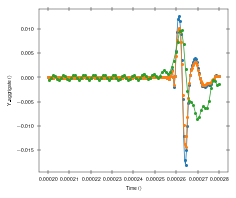

In [96]:

fig, ax = plt.subplots(1,1, figsize=(3.375, 3))
tmin= 200e-6
tmax = 280e-6
musphere_response = make_musphere_response(C0, response="exact", impedance=None)
Cbd = load_collection(fname, "X", musphere_response, 
                          differentiate=True, cutoff=1000e3, Npts="cutoff", 
                          shift=laser_delay, invert=False)

Cph = load_collection(fname, "Y", mic_response, 
                          differentiate=False, cutoff=200e3, Npts=int(25e6/(2*500e3)), 
                      shift=laser_delay+14e-6, invert=False)

gamma = 1.401
P0 = C0.cP * 1e3

Cbd.aggrigate()
Dbd = Cbd.agg
Dbd.plot(ax=ax, tmin=tmin, tmax=tmax, unit=-2e2, tunit=1, label=f"microsphere ({int(BW/1e3)} kHz)",
                 marker="o", ms=2, lw=0.75)


Dbd.x = (1 - 0.5*(gamma-1) * Dbd.x/c0)**(2*gamma/(gamma - 1)) - 1

Cph.aggrigate()
Dph = Cph.agg
Dph.x /= P0



Dbd.plot(ax=ax, tmin=tmin, tmax=tmax, unit=1, tunit=1, label=f"microsphere ({int(BW/1e3)} kHz)",
                 marker="o", ms=2, lw=0.75)
Dph.plot(ax=ax, tmin=tmin, tmax=tmax, unit=1, tunit=1, label=f"microsphere ({int(BW/1e3)} kHz)",
                 marker="o", ms=2, lw=0.75)




array([ 773.85623366,  922.14023166,  971.1703719 , ...,  992.88290924,
        845.11007354, 1000.        ])

In [256]:
enes = []
poss = []
for fname in fnames_ph:
    C = Collection(fname)
    poss.append(C.pos)
    enes.append(C.ene)
poss = np.unique(poss)
abs_pos = poss + pos0
enes = np.unique(enes)
print(enes)

[11.  12.5 14.  15.5 17. ]


In [258]:
fnames_ph = sort_fnames(find_files(experiment_ders[6]))
musphere_response = make_musphere_response(C0, response="bassetbound", impedance="plane", r0=0)
bd_cutoff = 1000e3

enes = []
poss = []
for fname in fnames_ph:
    C = Collection(fname)
    poss.append(C.pos)
    enes.append(C.ene)
poss = np.unique(poss)
abs_pos = poss + pos0
enes = np.unique(enes)

enes = enes[:]
fnamei = len(poss)
Cbds = np.zeros((len(enes), len(poss)), dtype="object")
Cphs = np.zeros((len(enes), len(poss)), dtype="object")
fnamei=0
for enei, ene in enumerate(enes):
    for posi, pos in enumerate(poss):
        fname = fnames_ph[fnamei]
        Cbd = load_collection(fname, "X", musphere_response, 
                      differentiate=True, cutoff=bd_cutoff, Npts="cutoff", shift=laser_delay, invert=False)
        Cph = load_collection(fname, "Y", mic_response, 
                      differentiate=False, cutoff=200e3, Npts=int(25e6/(2*200e3)), shift=laser_delay+14e-6, invert=False)
        Cbd.aggrigate()
        Cph.aggrigate()
        fnamei += 1
        Cbds[enei, posi] = Cbd
        Cphs[enei, posi] = Cph        

In [259]:
scaling_vals = {"sph": {"n": 3, "c": 0.611, "h": 5.89, "a":0.543, "b":4.61}, 
                "cyl": {"n": 2, "c": 0.555, "h": 4.80, "a":0.500, "b":4.00}, 
                "plane": {"n": 1, "c": 0.500, "h": 4.00, "a":0.444, "b":3.38}}

def excess_arrival_delay_funcs(pos, R0, c0, geometry):
    vals = scaling_vals[geometry]
    n, a, b = [vals[k] for k in "nab"]
    return (R0 * a / c0) * ((1+b*(pos/R0)**((n+2)/2))**(2/(n+2))-1) - pos/c0



12.5 0.0 0
12.5 0.0 1
12.5 0.0 2
12.5 0.0 3
12.5 0.0 4
12.5 0.0 5
12.5 0.0 6
12.5 0.0 7
12.5 0.0 8
12.5 0.0 9
12.5 0.0 avg
12.5 0.0 0
12.5 0.0 1
12.5 0.0 2
12.5 0.0 3
12.5 0.0 4
12.5 0.0 5
12.5 0.0 6
12.5 0.0 7
12.5 0.0 8
12.5 0.0 9
12.5 0.0 avg
12.5 0.10101010101010102 0
12.5 0.10101010101010102 1
12.5 0.10101010101010102 2
12.5 0.10101010101010102 3
12.5 0.10101010101010102 4
12.5 0.10101010101010102 5
12.5 0.10101010101010102 6
12.5 0.10101010101010102 7
12.5 0.10101010101010102 8
12.5 0.10101010101010102 9
12.5 0.10101010101010102 avg
12.5 0.10101010101010102 0
12.5 0.10101010101010102 1
12.5 0.10101010101010102 2
12.5 0.10101010101010102 3
12.5 0.10101010101010102 4
12.5 0.10101010101010102 5
12.5 0.10101010101010102 6
12.5 0.10101010101010102 7
12.5 0.10101010101010102 8
12.5 0.10101010101010102 9
12.5 0.10101010101010102 avg
12.5 0.20202020202020204 0
12.5 0.20202020202020204 1
12.5 0.20202020202020204 2
12.5 0.20202020202020204 3
12.5 0.20202020202020204 4
12.5 0.20202020202020

12.5 1.9191919191919191 avg
12.5 2.0202020202020203 0
12.5 2.0202020202020203 1
12.5 2.0202020202020203 2
12.5 2.0202020202020203 3
12.5 2.0202020202020203 4
12.5 2.0202020202020203 5
12.5 2.0202020202020203 6
12.5 2.0202020202020203 7
12.5 2.0202020202020203 8
12.5 2.0202020202020203 9
12.5 2.0202020202020203 avg
12.5 2.0202020202020203 0
12.5 2.0202020202020203 1
12.5 2.0202020202020203 2
12.5 2.0202020202020203 3
12.5 2.0202020202020203 4
12.5 2.0202020202020203 5
12.5 2.0202020202020203 6
12.5 2.0202020202020203 7
12.5 2.0202020202020203 8
12.5 2.0202020202020203 9
12.5 2.0202020202020203 avg
12.5 2.121212121212121 0
12.5 2.121212121212121 1
12.5 2.121212121212121 2
12.5 2.121212121212121 3
12.5 2.121212121212121 4
12.5 2.121212121212121 5
12.5 2.121212121212121 6
12.5 2.121212121212121 7
12.5 2.121212121212121 8
12.5 2.121212121212121 9
12.5 2.121212121212121 avg
12.5 2.121212121212121 0
12.5 2.121212121212121 1
12.5 2.121212121212121 2
12.5 2.121212121212121 3
12.5 2.121212121212

12.5 4.040404040404041 4
12.5 4.040404040404041 5
12.5 4.040404040404041 6
12.5 4.040404040404041 7
12.5 4.040404040404041 8
12.5 4.040404040404041 9
12.5 4.040404040404041 avg
12.5 4.141414141414142 0
12.5 4.141414141414142 1
12.5 4.141414141414142 2
12.5 4.141414141414142 3
12.5 4.141414141414142 4
12.5 4.141414141414142 5
12.5 4.141414141414142 6
12.5 4.141414141414142 7
12.5 4.141414141414142 8
12.5 4.141414141414142 9
12.5 4.141414141414142 avg
12.5 4.141414141414142 0
12.5 4.141414141414142 1
12.5 4.141414141414142 2
12.5 4.141414141414142 3
12.5 4.141414141414142 4
12.5 4.141414141414142 5
12.5 4.141414141414142 6
12.5 4.141414141414142 7
12.5 4.141414141414142 8
12.5 4.141414141414142 9
12.5 4.141414141414142 avg
12.5 4.242424242424242 0
12.5 4.242424242424242 1
12.5 4.242424242424242 2
12.5 4.242424242424242 3
12.5 4.242424242424242 4
12.5 4.242424242424242 5
12.5 4.242424242424242 6
12.5 4.242424242424242 7
12.5 4.242424242424242 8
12.5 4.242424242424242 9
12.5 4.242424242424

12.5 6.161616161616161 6
12.5 6.161616161616161 7
12.5 6.161616161616161 8
12.5 6.161616161616161 9
12.5 6.161616161616161 avg
12.5 6.161616161616161 0
12.5 6.161616161616161 1
12.5 6.161616161616161 2
12.5 6.161616161616161 3
12.5 6.161616161616161 4
12.5 6.161616161616161 5
12.5 6.161616161616161 6
12.5 6.161616161616161 7
12.5 6.161616161616161 8
12.5 6.161616161616161 9
12.5 6.161616161616161 avg
12.5 6.262626262626263 0
12.5 6.262626262626263 1
12.5 6.262626262626263 2
12.5 6.262626262626263 3
12.5 6.262626262626263 4
12.5 6.262626262626263 5
12.5 6.262626262626263 6
12.5 6.262626262626263 7
12.5 6.262626262626263 8
12.5 6.262626262626263 9
12.5 6.262626262626263 avg
12.5 6.262626262626263 0
12.5 6.262626262626263 1
12.5 6.262626262626263 2
12.5 6.262626262626263 3
12.5 6.262626262626263 4
12.5 6.262626262626263 5
12.5 6.262626262626263 6
12.5 6.262626262626263 7
12.5 6.262626262626263 8
12.5 6.262626262626263 9
12.5 6.262626262626263 avg
12.5 6.363636363636363 0
12.5 6.3636363636

12.5 8.181818181818182 8
12.5 8.181818181818182 9
12.5 8.181818181818182 avg
12.5 8.282828282828284 0
12.5 8.282828282828284 1
12.5 8.282828282828284 2
12.5 8.282828282828284 3
12.5 8.282828282828284 4
12.5 8.282828282828284 5
12.5 8.282828282828284 6
12.5 8.282828282828284 7
12.5 8.282828282828284 8
12.5 8.282828282828284 9
12.5 8.282828282828284 avg
12.5 8.282828282828284 0
12.5 8.282828282828284 1
12.5 8.282828282828284 2
12.5 8.282828282828284 3
12.5 8.282828282828284 4
12.5 8.282828282828284 5
12.5 8.282828282828284 6
12.5 8.282828282828284 7
12.5 8.282828282828284 8
12.5 8.282828282828284 9
12.5 8.282828282828284 avg
12.5 8.383838383838384 0
12.5 8.383838383838384 1
12.5 8.383838383838384 2
12.5 8.383838383838384 3
12.5 8.383838383838384 4
12.5 8.383838383838384 5
12.5 8.383838383838384 6
12.5 8.383838383838384 7
12.5 8.383838383838384 8
12.5 8.383838383838384 9
12.5 8.383838383838384 avg
12.5 8.383838383838384 0
12.5 8.383838383838384 1
12.5 8.383838383838384 2
12.5 8.3838383838

14.0 0.20202020202020204 9
14.0 0.20202020202020204 avg
14.0 0.20202020202020204 0
14.0 0.20202020202020204 1
14.0 0.20202020202020204 2
14.0 0.20202020202020204 3
14.0 0.20202020202020204 4
14.0 0.20202020202020204 5
14.0 0.20202020202020204 6
14.0 0.20202020202020204 7
14.0 0.20202020202020204 8
14.0 0.20202020202020204 9
14.0 0.20202020202020204 avg
14.0 0.30303030303030304 0
14.0 0.30303030303030304 1
14.0 0.30303030303030304 2
14.0 0.30303030303030304 3
14.0 0.30303030303030304 4
14.0 0.30303030303030304 5
14.0 0.30303030303030304 6
14.0 0.30303030303030304 7
14.0 0.30303030303030304 8
14.0 0.30303030303030304 9
14.0 0.30303030303030304 avg
14.0 0.30303030303030304 0
14.0 0.30303030303030304 1
14.0 0.30303030303030304 2
14.0 0.30303030303030304 3
14.0 0.30303030303030304 4
14.0 0.30303030303030304 5
14.0 0.30303030303030304 6
14.0 0.30303030303030304 7
14.0 0.30303030303030304 8
14.0 0.30303030303030304 9
14.0 0.30303030303030304 avg
14.0 0.4040404040404041 0
14.0 0.40404040404040

14.0 2.2222222222222223 8
14.0 2.2222222222222223 9
14.0 2.2222222222222223 avg
14.0 2.2222222222222223 0
14.0 2.2222222222222223 1
14.0 2.2222222222222223 2
14.0 2.2222222222222223 3
14.0 2.2222222222222223 4
14.0 2.2222222222222223 5
14.0 2.2222222222222223 6
14.0 2.2222222222222223 7
14.0 2.2222222222222223 8
14.0 2.2222222222222223 9
14.0 2.2222222222222223 avg
14.0 2.323232323232323 0
14.0 2.323232323232323 1
14.0 2.323232323232323 2
14.0 2.323232323232323 3
14.0 2.323232323232323 4
14.0 2.323232323232323 5
14.0 2.323232323232323 6
14.0 2.323232323232323 7
14.0 2.323232323232323 8
14.0 2.323232323232323 9
14.0 2.323232323232323 avg
14.0 2.323232323232323 0
14.0 2.323232323232323 1
14.0 2.323232323232323 2
14.0 2.323232323232323 3
14.0 2.323232323232323 4
14.0 2.323232323232323 5
14.0 2.323232323232323 6
14.0 2.323232323232323 7
14.0 2.323232323232323 8
14.0 2.323232323232323 9
14.0 2.323232323232323 avg
14.0 2.4242424242424243 0
14.0 2.4242424242424243 1
14.0 2.4242424242424243 2


14.0 4.040404040404041 5
14.0 4.040404040404041 6
14.0 4.040404040404041 7
14.0 4.040404040404041 8
14.0 4.040404040404041 9
14.0 4.040404040404041 avg
14.0 4.040404040404041 0
14.0 4.040404040404041 1
14.0 4.040404040404041 2
14.0 4.040404040404041 3
14.0 4.040404040404041 4
14.0 4.040404040404041 5
14.0 4.040404040404041 6
14.0 4.040404040404041 7
14.0 4.040404040404041 8
14.0 4.040404040404041 9
14.0 4.040404040404041 avg
14.0 4.141414141414142 0
14.0 4.141414141414142 1
14.0 4.141414141414142 2
14.0 4.141414141414142 3
14.0 4.141414141414142 4
14.0 4.141414141414142 5
14.0 4.141414141414142 6
14.0 4.141414141414142 7
14.0 4.141414141414142 8
14.0 4.141414141414142 9
14.0 4.141414141414142 avg
14.0 4.141414141414142 0
14.0 4.141414141414142 1
14.0 4.141414141414142 2
14.0 4.141414141414142 3
14.0 4.141414141414142 4
14.0 4.141414141414142 5
14.0 4.141414141414142 6
14.0 4.141414141414142 7
14.0 4.141414141414142 8
14.0 4.141414141414142 9
14.0 4.141414141414142 avg
14.0 4.2424242424

14.0 5.858585858585858 5
14.0 5.858585858585858 6
14.0 5.858585858585858 7
14.0 5.858585858585858 8
14.0 5.858585858585858 9
14.0 5.858585858585858 avg
14.0 5.858585858585858 0
14.0 5.858585858585858 1
14.0 5.858585858585858 2
14.0 5.858585858585858 3
14.0 5.858585858585858 4
14.0 5.858585858585858 5
14.0 5.858585858585858 6
14.0 5.858585858585858 7
14.0 5.858585858585858 8
14.0 5.858585858585858 9
14.0 5.858585858585858 avg
14.0 5.959595959595959 0
14.0 5.959595959595959 1
14.0 5.959595959595959 2
14.0 5.959595959595959 3
14.0 5.959595959595959 4
14.0 5.959595959595959 5
14.0 5.959595959595959 6
14.0 5.959595959595959 7
14.0 5.959595959595959 8
14.0 5.959595959595959 9
14.0 5.959595959595959 avg
14.0 5.959595959595959 0
14.0 5.959595959595959 1
14.0 5.959595959595959 2
14.0 5.959595959595959 3
14.0 5.959595959595959 4
14.0 5.959595959595959 5
14.0 5.959595959595959 6
14.0 5.959595959595959 7
14.0 5.959595959595959 8
14.0 5.959595959595959 9
14.0 5.959595959595959 avg
14.0 6.0606060606

14.0 7.373737373737374 6
14.0 7.373737373737374 7
14.0 7.373737373737374 8
14.0 7.373737373737374 9
14.0 7.373737373737374 avg
14.0 7.373737373737374 0
14.0 7.373737373737374 1
14.0 7.373737373737374 2
14.0 7.373737373737374 3
14.0 7.373737373737374 4
14.0 7.373737373737374 5
14.0 7.373737373737374 6
14.0 7.373737373737374 7
14.0 7.373737373737374 8
14.0 7.373737373737374 9
14.0 7.373737373737374 avg
14.0 7.474747474747475 0
14.0 7.474747474747475 1
14.0 7.474747474747475 2
14.0 7.474747474747475 3
14.0 7.474747474747475 4
14.0 7.474747474747475 5
14.0 7.474747474747475 6
14.0 7.474747474747475 7
14.0 7.474747474747475 8
14.0 7.474747474747475 9
14.0 7.474747474747475 avg
14.0 7.474747474747475 0
14.0 7.474747474747475 1
14.0 7.474747474747475 2
14.0 7.474747474747475 3
14.0 7.474747474747475 4
14.0 7.474747474747475 5
14.0 7.474747474747475 6
14.0 7.474747474747475 7
14.0 7.474747474747475 8
14.0 7.474747474747475 9
14.0 7.474747474747475 avg
14.0 7.575757575757576 0
14.0 7.5757575757

14.0 8.98989898989899 9
14.0 8.98989898989899 avg
14.0 9.09090909090909 0
14.0 9.09090909090909 1
14.0 9.09090909090909 2
14.0 9.09090909090909 3
14.0 9.09090909090909 4
14.0 9.09090909090909 5
14.0 9.09090909090909 6
14.0 9.09090909090909 7
14.0 9.09090909090909 8
14.0 9.09090909090909 9
14.0 9.09090909090909 avg
14.0 9.09090909090909 0
14.0 9.09090909090909 1
14.0 9.09090909090909 2
14.0 9.09090909090909 3
14.0 9.09090909090909 4
14.0 9.09090909090909 5
14.0 9.09090909090909 6
14.0 9.09090909090909 7
14.0 9.09090909090909 8
14.0 9.09090909090909 9
14.0 9.09090909090909 avg
14.0 9.191919191919192 0
14.0 9.191919191919192 1
14.0 9.191919191919192 2
14.0 9.191919191919192 3
14.0 9.191919191919192 4
14.0 9.191919191919192 5
14.0 9.191919191919192 6
14.0 9.191919191919192 7
14.0 9.191919191919192 8
14.0 9.191919191919192 9
14.0 9.191919191919192 avg
14.0 9.191919191919192 0
14.0 9.191919191919192 1
14.0 9.191919191919192 2
14.0 9.191919191919192 3
14.0 9.191919191919192 4
14.0 9.191919191

15.5 0.6060606060606061 7
15.5 0.6060606060606061 8
15.5 0.6060606060606061 9
15.5 0.6060606060606061 avg
15.5 0.7070707070707071 0
15.5 0.7070707070707071 1
15.5 0.7070707070707071 2
15.5 0.7070707070707071 3
15.5 0.7070707070707071 4
15.5 0.7070707070707071 5
15.5 0.7070707070707071 6
15.5 0.7070707070707071 7
15.5 0.7070707070707071 8
15.5 0.7070707070707071 9
15.5 0.7070707070707071 avg
15.5 0.7070707070707071 0
15.5 0.7070707070707071 1
15.5 0.7070707070707071 2
15.5 0.7070707070707071 3
15.5 0.7070707070707071 4
15.5 0.7070707070707071 5
15.5 0.7070707070707071 6
15.5 0.7070707070707071 7
15.5 0.7070707070707071 8
15.5 0.7070707070707071 9
15.5 0.7070707070707071 avg
15.5 0.8080808080808082 0
15.5 0.8080808080808082 1
15.5 0.8080808080808082 2
15.5 0.8080808080808082 3
15.5 0.8080808080808082 4
15.5 0.8080808080808082 5
15.5 0.8080808080808082 6
15.5 0.8080808080808082 7
15.5 0.8080808080808082 8
15.5 0.8080808080808082 9
15.5 0.8080808080808082 avg
15.5 0.8080808080808082 0
15.5

15.5 2.323232323232323 7
15.5 2.323232323232323 8
15.5 2.323232323232323 9
15.5 2.323232323232323 avg
15.5 2.4242424242424243 0
15.5 2.4242424242424243 1
15.5 2.4242424242424243 2
15.5 2.4242424242424243 3
15.5 2.4242424242424243 4
15.5 2.4242424242424243 5
15.5 2.4242424242424243 6
15.5 2.4242424242424243 7
15.5 2.4242424242424243 8
15.5 2.4242424242424243 9
15.5 2.4242424242424243 avg
15.5 2.4242424242424243 0
15.5 2.4242424242424243 1
15.5 2.4242424242424243 2
15.5 2.4242424242424243 3
15.5 2.4242424242424243 4
15.5 2.4242424242424243 5
15.5 2.4242424242424243 6
15.5 2.4242424242424243 7
15.5 2.4242424242424243 8
15.5 2.4242424242424243 9
15.5 2.4242424242424243 avg
15.5 2.5252525252525255 0
15.5 2.5252525252525255 1
15.5 2.5252525252525255 2
15.5 2.5252525252525255 3
15.5 2.5252525252525255 4
15.5 2.5252525252525255 5
15.5 2.5252525252525255 6
15.5 2.5252525252525255 7
15.5 2.5252525252525255 8
15.5 2.5252525252525255 9
15.5 2.5252525252525255 avg
15.5 2.5252525252525255 0
15.5 2.5

15.5 4.040404040404041 1
15.5 4.040404040404041 2
15.5 4.040404040404041 3
15.5 4.040404040404041 4
15.5 4.040404040404041 5
15.5 4.040404040404041 6
15.5 4.040404040404041 7
15.5 4.040404040404041 8
15.5 4.040404040404041 9
15.5 4.040404040404041 avg
15.5 4.141414141414142 0
15.5 4.141414141414142 1
15.5 4.141414141414142 2
15.5 4.141414141414142 3
15.5 4.141414141414142 4
15.5 4.141414141414142 5
15.5 4.141414141414142 6
15.5 4.141414141414142 7
15.5 4.141414141414142 8
15.5 4.141414141414142 9
15.5 4.141414141414142 avg
15.5 4.141414141414142 0
15.5 4.141414141414142 1
15.5 4.141414141414142 2
15.5 4.141414141414142 3
15.5 4.141414141414142 4
15.5 4.141414141414142 5
15.5 4.141414141414142 6
15.5 4.141414141414142 7
15.5 4.141414141414142 8
15.5 4.141414141414142 9
15.5 4.141414141414142 avg
15.5 4.242424242424242 0
15.5 4.242424242424242 1
15.5 4.242424242424242 2
15.5 4.242424242424242 3
15.5 4.242424242424242 4
15.5 4.242424242424242 5
15.5 4.242424242424242 6
15.5 4.242424242424

15.5 5.757575757575758 0
15.5 5.757575757575758 1
15.5 5.757575757575758 2
15.5 5.757575757575758 3
15.5 5.757575757575758 4
15.5 5.757575757575758 5
15.5 5.757575757575758 6
15.5 5.757575757575758 7
15.5 5.757575757575758 8
15.5 5.757575757575758 9
15.5 5.757575757575758 avg
15.5 5.757575757575758 0
15.5 5.757575757575758 1
15.5 5.757575757575758 2
15.5 5.757575757575758 3
15.5 5.757575757575758 4
15.5 5.757575757575758 5
15.5 5.757575757575758 6
15.5 5.757575757575758 7
15.5 5.757575757575758 8
15.5 5.757575757575758 9
15.5 5.757575757575758 avg
15.5 5.858585858585858 0
15.5 5.858585858585858 1
15.5 5.858585858585858 2
15.5 5.858585858585858 3
15.5 5.858585858585858 4
15.5 5.858585858585858 5
15.5 5.858585858585858 6
15.5 5.858585858585858 7
15.5 5.858585858585858 8
15.5 5.858585858585858 9
15.5 5.858585858585858 avg
15.5 5.858585858585858 0
15.5 5.858585858585858 1
15.5 5.858585858585858 2
15.5 5.858585858585858 3
15.5 5.858585858585858 4
15.5 5.858585858585858 5
15.5 5.858585858585

15.5 7.373737373737374 3
15.5 7.373737373737374 4
15.5 7.373737373737374 5
15.5 7.373737373737374 6
15.5 7.373737373737374 7
15.5 7.373737373737374 8
15.5 7.373737373737374 9
15.5 7.373737373737374 avg
15.5 7.474747474747475 0
15.5 7.474747474747475 1
15.5 7.474747474747475 2
15.5 7.474747474747475 3
15.5 7.474747474747475 4
15.5 7.474747474747475 5
15.5 7.474747474747475 6
15.5 7.474747474747475 7
15.5 7.474747474747475 8
15.5 7.474747474747475 9
15.5 7.474747474747475 avg
15.5 7.474747474747475 0
15.5 7.474747474747475 1
15.5 7.474747474747475 2
15.5 7.474747474747475 3
15.5 7.474747474747475 4
15.5 7.474747474747475 5
15.5 7.474747474747475 6
15.5 7.474747474747475 7
15.5 7.474747474747475 8
15.5 7.474747474747475 9
15.5 7.474747474747475 avg
15.5 7.575757575757576 0
15.5 7.575757575757576 1
15.5 7.575757575757576 2
15.5 7.575757575757576 3
15.5 7.575757575757576 4
15.5 7.575757575757576 5
15.5 7.575757575757576 6
15.5 7.575757575757576 7
15.5 7.575757575757576 8
15.5 7.575757575757

15.5 9.09090909090909 4
15.5 9.09090909090909 5
15.5 9.09090909090909 6
15.5 9.09090909090909 7
15.5 9.09090909090909 8
15.5 9.09090909090909 9
15.5 9.09090909090909 avg
15.5 9.09090909090909 0
15.5 9.09090909090909 1
15.5 9.09090909090909 2
15.5 9.09090909090909 3
15.5 9.09090909090909 4
15.5 9.09090909090909 5
15.5 9.09090909090909 6
15.5 9.09090909090909 7
15.5 9.09090909090909 8
15.5 9.09090909090909 9
15.5 9.09090909090909 avg
15.5 9.191919191919192 0
15.5 9.191919191919192 1
15.5 9.191919191919192 2
15.5 9.191919191919192 3
15.5 9.191919191919192 4
15.5 9.191919191919192 5
15.5 9.191919191919192 6
15.5 9.191919191919192 7
15.5 9.191919191919192 8
15.5 9.191919191919192 9
15.5 9.191919191919192 avg
15.5 9.191919191919192 0
15.5 9.191919191919192 1
15.5 9.191919191919192 2
15.5 9.191919191919192 3
15.5 9.191919191919192 4
15.5 9.191919191919192 5
15.5 9.191919191919192 6
15.5 9.191919191919192 7
15.5 9.191919191919192 8
15.5 9.191919191919192 9
15.5 9.191919191919192 avg
15.5 9.292

17.0 0.6060606060606061 3
17.0 0.6060606060606061 4
17.0 0.6060606060606061 5
17.0 0.6060606060606061 6
17.0 0.6060606060606061 7
17.0 0.6060606060606061 8
17.0 0.6060606060606061 9
17.0 0.6060606060606061 avg
17.0 0.7070707070707071 0
17.0 0.7070707070707071 1
17.0 0.7070707070707071 2
17.0 0.7070707070707071 3
17.0 0.7070707070707071 4
17.0 0.7070707070707071 5
17.0 0.7070707070707071 6
17.0 0.7070707070707071 7
17.0 0.7070707070707071 8
17.0 0.7070707070707071 9
17.0 0.7070707070707071 avg
17.0 0.7070707070707071 0
17.0 0.7070707070707071 1
17.0 0.7070707070707071 2
17.0 0.7070707070707071 3
17.0 0.7070707070707071 4
17.0 0.7070707070707071 5
17.0 0.7070707070707071 6
17.0 0.7070707070707071 7
17.0 0.7070707070707071 8
17.0 0.7070707070707071 9
17.0 0.7070707070707071 avg
17.0 0.8080808080808082 0
17.0 0.8080808080808082 1
17.0 0.8080808080808082 2
17.0 0.8080808080808082 3
17.0 0.8080808080808082 4
17.0 0.8080808080808082 5
17.0 0.8080808080808082 6
17.0 0.8080808080808082 7
17.0 0

17.0 2.323232323232323 7
17.0 2.323232323232323 8
17.0 2.323232323232323 9
17.0 2.323232323232323 avg
17.0 2.323232323232323 0
17.0 2.323232323232323 1
17.0 2.323232323232323 2
17.0 2.323232323232323 3
17.0 2.323232323232323 4
17.0 2.323232323232323 5
17.0 2.323232323232323 6
17.0 2.323232323232323 7
17.0 2.323232323232323 8
17.0 2.323232323232323 9
17.0 2.323232323232323 avg
17.0 2.4242424242424243 0
17.0 2.4242424242424243 1
17.0 2.4242424242424243 2
17.0 2.4242424242424243 3
17.0 2.4242424242424243 4
17.0 2.4242424242424243 5
17.0 2.4242424242424243 6
17.0 2.4242424242424243 7
17.0 2.4242424242424243 8
17.0 2.4242424242424243 9
17.0 2.4242424242424243 avg
17.0 2.4242424242424243 0
17.0 2.4242424242424243 1
17.0 2.4242424242424243 2
17.0 2.4242424242424243 3
17.0 2.4242424242424243 4
17.0 2.4242424242424243 5
17.0 2.4242424242424243 6
17.0 2.4242424242424243 7
17.0 2.4242424242424243 8
17.0 2.4242424242424243 9
17.0 2.4242424242424243 avg
17.0 2.5252525252525255 0
17.0 2.525252525252

17.0 3.9393939393939394 4
17.0 3.9393939393939394 5
17.0 3.9393939393939394 6
17.0 3.9393939393939394 7
17.0 3.9393939393939394 8
17.0 3.9393939393939394 9
17.0 3.9393939393939394 avg
17.0 4.040404040404041 0
17.0 4.040404040404041 1
17.0 4.040404040404041 2
17.0 4.040404040404041 3
17.0 4.040404040404041 4
17.0 4.040404040404041 5
17.0 4.040404040404041 6
17.0 4.040404040404041 7
17.0 4.040404040404041 8
17.0 4.040404040404041 9
17.0 4.040404040404041 avg
17.0 4.040404040404041 0
17.0 4.040404040404041 1
17.0 4.040404040404041 2
17.0 4.040404040404041 3
17.0 4.040404040404041 4
17.0 4.040404040404041 5
17.0 4.040404040404041 6
17.0 4.040404040404041 7
17.0 4.040404040404041 8
17.0 4.040404040404041 9
17.0 4.040404040404041 avg
17.0 4.141414141414142 0
17.0 4.141414141414142 1
17.0 4.141414141414142 2
17.0 4.141414141414142 3
17.0 4.141414141414142 4
17.0 4.141414141414142 5
17.0 4.141414141414142 6
17.0 4.141414141414142 7
17.0 4.141414141414142 8
17.0 4.141414141414142 9
17.0 4.14141

17.0 5.555555555555555 9
17.0 5.555555555555555 avg
17.0 5.656565656565657 0
17.0 5.656565656565657 1
17.0 5.656565656565657 2
17.0 5.656565656565657 3
17.0 5.656565656565657 4
17.0 5.656565656565657 5
17.0 5.656565656565657 6
17.0 5.656565656565657 7
17.0 5.656565656565657 8
17.0 5.656565656565657 9
17.0 5.656565656565657 avg
17.0 5.656565656565657 0
17.0 5.656565656565657 1
17.0 5.656565656565657 2
17.0 5.656565656565657 3
17.0 5.656565656565657 4
17.0 5.656565656565657 5
17.0 5.656565656565657 6
17.0 5.656565656565657 7
17.0 5.656565656565657 8
17.0 5.656565656565657 9
17.0 5.656565656565657 avg
17.0 5.757575757575758 0
17.0 5.757575757575758 1
17.0 5.757575757575758 2
17.0 5.757575757575758 3
17.0 5.757575757575758 4
17.0 5.757575757575758 5
17.0 5.757575757575758 6
17.0 5.757575757575758 7
17.0 5.757575757575758 8
17.0 5.757575757575758 9
17.0 5.757575757575758 avg
17.0 5.757575757575758 0
17.0 5.757575757575758 1
17.0 5.757575757575758 2
17.0 5.757575757575758 3
17.0 5.7575757575

17.0 7.575757575757576 3
17.0 7.575757575757576 4
17.0 7.575757575757576 5
17.0 7.575757575757576 6
17.0 7.575757575757576 7
17.0 7.575757575757576 8
17.0 7.575757575757576 9
17.0 7.575757575757576 avg
17.0 7.575757575757576 0
17.0 7.575757575757576 1
17.0 7.575757575757576 2
17.0 7.575757575757576 3
17.0 7.575757575757576 4
17.0 7.575757575757576 5
17.0 7.575757575757576 6
17.0 7.575757575757576 7
17.0 7.575757575757576 8
17.0 7.575757575757576 9
17.0 7.575757575757576 avg
17.0 7.6767676767676765 0
17.0 7.6767676767676765 1
17.0 7.6767676767676765 2
17.0 7.6767676767676765 3
17.0 7.6767676767676765 4
17.0 7.6767676767676765 5
17.0 7.6767676767676765 6
17.0 7.6767676767676765 7
17.0 7.6767676767676765 8
17.0 7.6767676767676765 9
17.0 7.6767676767676765 avg
17.0 7.6767676767676765 0
17.0 7.6767676767676765 1
17.0 7.6767676767676765 2
17.0 7.6767676767676765 3
17.0 7.6767676767676765 4
17.0 7.6767676767676765 5
17.0 7.6767676767676765 6
17.0 7.6767676767676765 7
17.0 7.6767676767676765 8

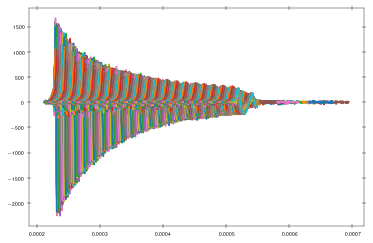

In [261]:
import matplotlib.gridspec as gridspec

t0 = 220e-6
Dt = 200e-6
factor = 0.1

Nshots = 10
shots = list(range(Nshots)) + ["avg"]


pulse_timings = np.zeros((2, len(enes), len(poss), len(shots), 4))
pulse_peaks = np.zeros((2, len(enes), len(poss), len(shots), 4))


for enei, ene in enumerate(enes[1:]):
    enei+=1
    for posi, pos in enumerate(poss):
        Cbd = Cbds[enei, posi]
        Cph = Cphs[enei, posi]
        #Cbd.aggrigate(collection_slice=25)
        #Cph.aggrigate(collection_slice=25)
        for Ci, C in enumerate((Cbd, Cph)):
            for shoti, shotnum in enumerate(shots):
                if shotnum == "avg":
                    D = C.agg
                else:
                    try:
                        D = C.collection[shotnum]
                    except: continue
                # initial window
                tmin = t0 + pos*1e-2/c0
                tmax = t0 + pos*1e-2/c0 + Dt
                ts, xs = D.time_gate(tmin, tmax)
                # refine window
                ttrough = ts[np.argmin(xs)]
                tmin = ttrough - 20e-6
                tmax = ttrough + 20e-6
                print(ene, pos, shotnum)
                ts, xs = D.time_gate(tmin, tmax)
                plt.plot(ts, xs)
                timings, peaks = pulse_params(D, tmin=tmin, tmax=tmax, factor=factor)
                pulse_timings[Ci, enei, posi, shoti, :] = timings
                pulse_peaks[Ci, enei, posi, shoti, :] = peaks


In [263]:
def plot_series(ax, plot_eneis, plot_posis, plot_Cis, plot_shotis, pulse_peaks):
    for enei, ene in enumerate(enes[1:]):
        enei+=1
        alpha = (ene/enes[-1])**3
        for posi, pos in enumerate(poss):
            Cbd = Cbds[enei, posi]
            Cph = Cphs[enei, posi]
            for Ci, C in enumerate((Cbd, Cph)):
                tpeak, Ppeak, ttrough, Ptrough = pulse_peaks[Ci, enei, posi, shoti, :]
                if Ci == 0:
                    marker = "o"
                    ls = "-"
                if Ci == 1:
                    marker = "s"
                    ls = "--"
                if shotnum == "avg":
                    D = C.agg
                else:
                    D = C.collection[shotnum]

                tmin = ttrough - 15e-6
                tmax = ttrough + 15e-6
                ts, xs = D.time_gate(tmin, tmax)
                if posi in plot_posis and enei in plot_eneis and Ci in plot_Cis:
                    c = colors[posi + Ci]
                    D.plot(ax=ax, tmin=ttrough-15e-6, tmax=ttrough+15e-6,
                       tunit="us", unit="Pa", zorder=posi, color=c, ls=ls, alpha=alpha, lw=0.75)

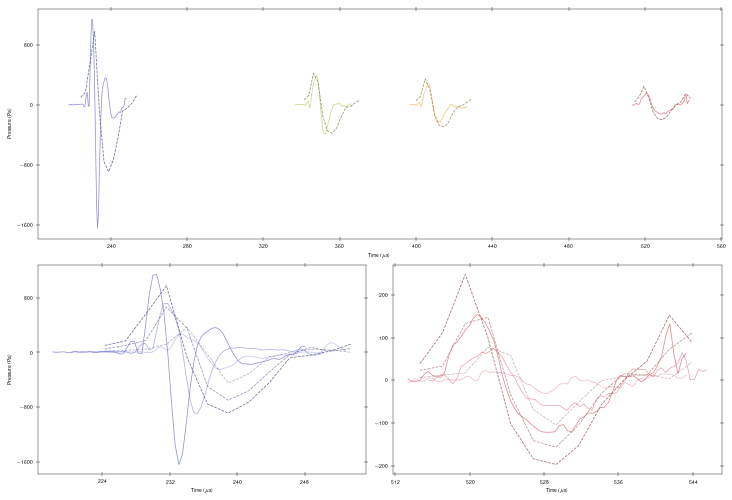

In [305]:
import matplotlib.ticker as ticker


plot_posis = [0, 40, 60, 99]
plot_Cis = [0, 1]
plot_shotis = [3]

color_set =  plt.cm.tab20b(np.arange(4*len(plot_posis)))
colors = {}
for ppi, plot_posi in enumerate(plot_posis):
    for Ci in range(2):
        colors[plot_posi+Ci] = color_set[ppi*4 + (1-Ci)*2]



fig = plt.figure(figsize=(3*3.375, 3*2.3))
gs = gridspec.GridSpec(2, 2, height_ratios=[1.1, 1])
ax = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
axs = [ax1, ax2]


plot_eneis = [3]
plot_series(ax, plot_eneis, plot_posis, plot_Cis, plot_shotis, pulse_peaks)
ax.set_ylabel("Pressure (Pa)")
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

first = True
for posi, pos in enumerate(abs_pos):
    if posi in plot_posis:
        if first:
            label = "$x_0=%s$ mm"%round(pos*10, 1)
        else:
            label = "%s mm"%round(pos*10, 1)
        tpeak, peak, ttrough, trough = pulse_peaks[plot_Cis[0], plot_eneis[0], posi, plot_shotis[0], :]
        #ax.text(ttrough*1e6 + 2, trough, label, ha="left", va="bottom")
        first = False
    

plot_eneis = [0,1,2,3]
plot_posis = [0]
plot_series(axs[0], plot_eneis, plot_posis, plot_Cis, plot_shotis, pulse_peaks)
axs[0].set_ylabel("Pressure (Pa)")
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(5))
axs[0].yaxis.set_major_locator(ticker.MaxNLocator(5))

plot_eneis = [0,1,2,3]
plot_posis = [99]
plot_series(axs[1], plot_eneis, plot_posis, plot_Cis, plot_shotis, pulse_peaks)
axs[1].set_ylabel(None)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(5))
axs[1].yaxis.set_major_locator(ticker.MaxNLocator(5))

plt.tight_layout()
#plt.savefig(f"figures/laser-pos-ene-scan_time_series.pdf")
#plt.savefig(f"figures/laser-pos-ene-scan_time_series.png", dpi=600)


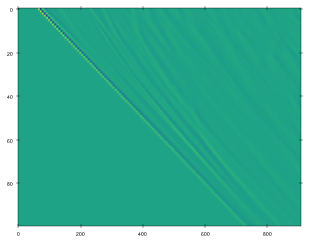

In [270]:
xs = []
for C in Cbds[-1,:]:
    t, x = C.collection[5].time_gate(tmin=200e-6, tmax=600e-6)
    xs.append(x)
xs = np.array(xs)
plt.imshow(xs, aspect=7)

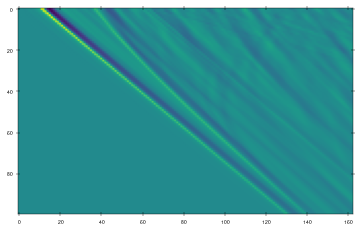

In [271]:
xs = []
for C in Cphs[-1,:]:
    t, x = C.collection[5].time_gate(tmin=200e-6, tmax=600e-6)
    xs.append(x)
xs = np.array(xs)
plt.imshow(xs, aspect=1)

In [272]:
def fit_powerlaw(x, y, dy, p0):
    popt, pcov = curve_fit(powerlaw, x, y, p0=p0, sigma=dy, absolute_sigma=True,
                                     bounds=[(-np.inf, -np.inf), (np.inf, np.inf)])
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

def fit_line(x, y, dy):
    speed = np.mean(np.diff(x) / np.diff(y))
    print(speed)
    popt, pcov = curve_fit(line, x, y, p0=[speed, x[0]], sigma=dy, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    return popt, perr



14.0
0.03445550583597713
0.035004489779512794
15.5
0.03466604476705487
0.034161965980147875
17.0
0.03466604476705491
0.03413159978816541


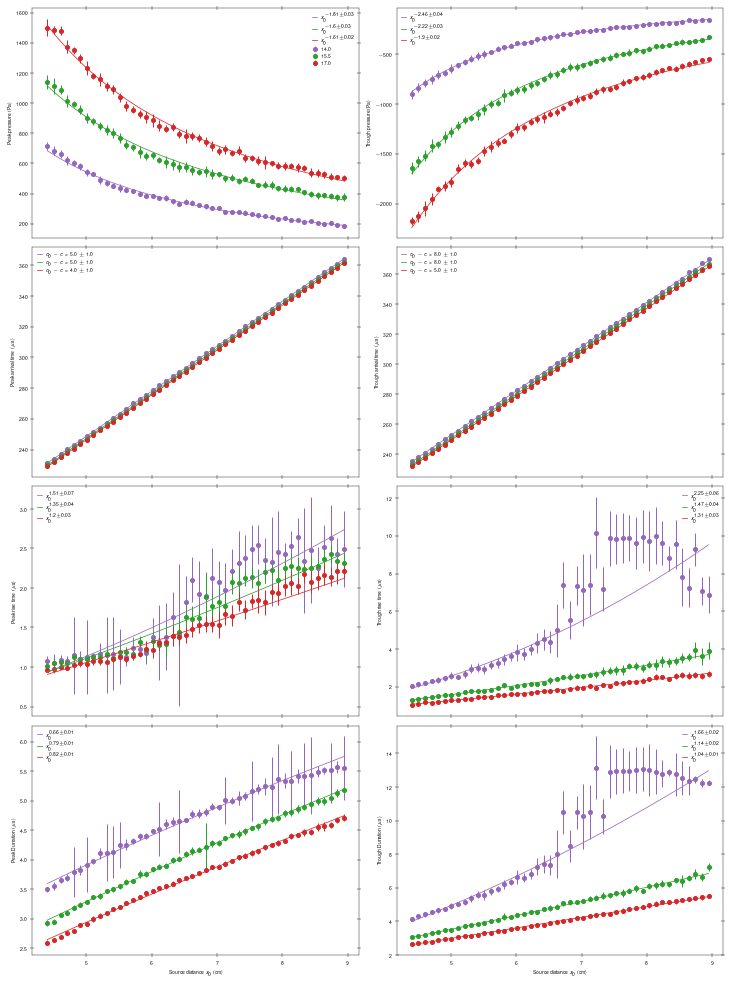

In [317]:
shoti = -1
fig, axs = plt.subplots(4, 2, figsize=(3*3.375, 3*3.4*4/3), sharex=True)
ene_names = enes
pos_mask = abs_pos < 9

for ene in enes[2:]:
    print(ene)
    c = f"C{enei}"
    fc =c
    enei = list(enes).index(ene)
    ene_name = ene_names[enei]
    for Ci in range(1):
        if Ci == 0:
            marker="o"
        else:
            marker="s"
        dt_f, Dt_f, dt_r, Dt_r = [pulse_timings[Ci, enei, pos_mask, shoti, i] for i in range(4)]
        ddt_f, dDt_f, ddt_r, dDt_r = [np.std(pulse_timings[Ci, enei, pos_mask, :-1, i], axis=1) for i in range(4)]
        tpeak, Ppeak, ttrough, Ptrough = [pulse_peaks[Ci, enei, pos_mask, shoti, i] for i in range(4)]
        dtpeak, dPpeak, dttrough, dPtrough = [np.std(pulse_peaks[Ci, enei, pos_mask, :-1, i], axis=1) for i in range(4)]
        
        use_pos = abs_pos[pos_mask]
        
        dtpeak  = np.sqrt(dtpeak**2 + (1/(bd_cutoff*2))**2)
        
        popt_Ppeak, perr_Ppeak = fit_powerlaw(use_pos, Ppeak, dPpeak, [10000.0, -1.0])
        popt_tpeak, perr_tpeak = fit_line(use_pos, tpeak*1e6, dtpeak*1e6)
        popt_tpeak0 = [(c0*1e2/1e6), popt_tpeak[1]]
        popt_dt_f, perr_dt_f = fit_powerlaw(use_pos, dt_f, ddt_f, [10.0, 1.0])
        popt_Dt_f, perr_Dt_f = fit_powerlaw(use_pos, Dt_f, dDt_f, [10.0, 1.0])
        
        popt_Ptrough, perr_Ptrough = fit_powerlaw(use_pos, Ptrough, dPtrough, [-10000.0, -1.0])
        popt_ttrough, perr_ttrough = fit_line(use_pos, ttrough*1e6, dttrough)
        popt_ttrough0 = [c0*1e2/1e6, popt_ttrough[1]]
        popt_dt_r, perr_dt_r = fit_powerlaw(use_pos, dt_r, ddt_r, [10.0, 1.0])
        popt_Dt_r, perr_Dt_r = fit_powerlaw(use_pos, Dt_r, dDt_r, [10.0, 1.0])
        
        
        axs[0,0].errorbar(use_pos, Ppeak, yerr=dPpeak, 
                          mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci, label=ene_name)     
        axs[0,0].plot(use_pos, powerlaw(use_pos, *popt_Ppeak), lw=0.75, c=c, 
                      label="$x_0^{%s \pm %s}$" % (round(popt_Ppeak[1],2), round(perr_Ppeak[1],2)))
        
        axs[1,0].errorbar(use_pos, 1e6*(tpeak), yerr=1e6*dtpeak, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)        
        axs[1,0].plot(use_pos, line(use_pos, *popt_tpeak), lw=0.75, c=c,
                     label=r"$c_0-c=%s\pm %s$" % (round(c0 - popt_tpeak[0]*1e6/1e2, 0), round(perr_tpeak[0]*1e6/1e2, 0)))
        
        axs[2,0].errorbar(use_pos, 1e6*dt_f, yerr=1e6*ddt_f, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[2,0].plot(use_pos, powerlaw(use_pos, *popt_dt_f)*1e6, lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_dt_f[1],2), round(perr_dt_f[1],2)))
        axs[3,0].errorbar(use_pos, 1e6*Dt_f, yerr=1e6*dDt_f, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[3,0].plot(use_pos, powerlaw(use_pos, *popt_Dt_f)*1e6, lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_Dt_f[1],2), round(perr_Dt_f[1],2)))
            
        axs[0,1].errorbar(use_pos, Ptrough, yerr=dPtrough, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)     
        
        axs[0,1].plot(use_pos, powerlaw(use_pos, *popt_Ptrough), lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_Ptrough[1],2), round(perr_Ptrough[1],2)))
       
        axs[1,1].errorbar(use_pos, 1e6*(ttrough), yerr=1e6*dttrough, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[1,1].plot(use_pos, line(use_pos, *popt_ttrough), lw=0.75, c=c,
                     label=r"$c_0-c=%s\pm %s$" % (round(c0 - popt_ttrough[0]*1e6/1e2, 0), round(perr_tpeak[0]*1e6/1e2, 0)))
        
        axs[2,1].errorbar(use_pos, 1e6*dt_r, yerr=1e6*ddt_r, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)        
        axs[2,1].plot(use_pos, powerlaw(use_pos, *popt_dt_r)*1e6, lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_dt_r[1],2), round(perr_dt_r[1],2)))
        axs[3,1].errorbar(use_pos, 1e6*Dt_r, yerr=1e6*dDt_r, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[3,1].plot(use_pos, powerlaw(use_pos, *popt_Dt_r)*1e6, lw=0.75, c=c,
                      label="$x_0^{%s \pm %s}$" % (round(popt_Dt_r[1],2), round(perr_Dt_r[1],2)))
        
        for axr in axs:
            for ax in axr:
                ax.legend(frameon=False, handlelength=1)

        

axs[2,0].legend(frameon=False, handlelength=1, loc="upper left")
axs[0,0].set_ylabel(r"Peak pressure (Pa)")
axs[1,0].set_ylabel(r"Peak arrival time (${\rm \mu s}$)")
axs[2,0].set_ylabel(r"Peak rise time (${\rm \mu s}$)")
axs[3,0].set_ylabel(r"Peak Durration (${\rm \mu s}$)")


axs[0,1].set_ylabel("Trough pressure (Pa)")
axs[1,1].set_ylabel(r"Trough arrival time (${\rm \mu s}$)")
axs[2,1].set_ylabel(r"Trough rise time (${\rm \mu s}$)")
axs[3,1].set_ylabel(r"Trough Durration (${\rm \mu s}$)")

axs[3,0].set_xlabel("Source distance $x_0$ (cm)")
axs[3,1].set_xlabel("Source distance $x_0$ (cm)")

plt.tight_layout()
#plt.savefig("figures/laser-pos-ene-scan_pulse_params.pdf")
#plt.savefig("figures/laser-pos-ene-scan_pulse_params.png", dpi=600)
       

# Slow flown ene pos scan

In [1307]:
160-115, 135-92

(45, 43)

In [1145]:
musphere_response = make_musphere_response(C0, response="bassetbound", impedance=None, r0=0)
bd_cutoff = 1000e3

enes = []
poss = []
for fname in fnames_fl:
    C = Collection(fname)
    poss.append(C.pos)
    enes.append(C.ene)
poss = np.unique(poss)
enes = np.unique(enes)

enes = enes[1:]
fnamei = len(poss)
Cbd2s = np.zeros((len(enes), len(poss)), dtype="object")
Cfls = np.zeros((len(enes), len(poss)), dtype="object")
for enei, ene in enumerate(enes):
    for posi, pos in enumerate(poss):
        fname = fnames[fnamei]
        Cbd2 = load_collection(fname, "X", musphere_response, 
                      differentiate=True, cutoff=bd_cutoff, Npts="cutoff", shift=0, invert=False)
        Cfl = load_collection(fname, "Y", muflown_response, 
                      differentiate=False, cutoff=300e3, Npts=int(25e6/(2*300e3)), shift=29e-6, invert=False)
        Cbd2.aggrigate()
        Cfl.aggrigate()
        fnamei += 1
        Cbd2s[enei, posi] = Cbd2
        Cfls[enei, posi] = Cfl      

0.0 0.0 0.0
14.0 14.0 14.0



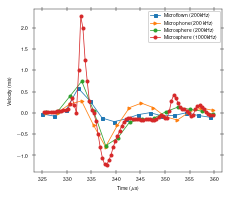

In [1275]:
tmin= 325e-6
tmax = 360e-6
fig, ax = plt.subplots(1,1, figsize=(3.375, 3))

fname_fl = fnames_fl[12*1+0]
fname_ph = fnames_ph[12*1+0]
fname_nbd = fnames_nbd[1]

musphere_response = make_musphere_response(C0, response="exact", impedance=None)
VR = VelocityResponse(1/C0.cal, C0.R, C0.rho, C0.Tavg, C0.cRH, C0.k)
Z0 = VR.Z0

Cfl = load_collection(fname_fl, "Y", muflown_response, 
                          differentiate=False, cutoff=200e3, Npts="cutoff", shift=30e-6, invert=False)
Cfl.aggrigate(collection_slice=10)
Cfl.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us", zorder=0,
                marker="s", ms=3, lw=0.75, label=f"Microflown (200 kHz)")

Cph = load_collection(fname_ph, "Y", mic_response, 
                          differentiate=False, cutoff=200e3, Npts="cutoff", shift=22e-6, invert=False)
Cph.apply("calibrate", cal=1/Z0/2, inplace=True)
Cph.aggrigate(collection_slice=10)
Cph.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us", zorder=0,
                marker=">", ms=3, lw=0.75, label=f"Microphone (200 kHz)")

Cnbd = load_collection(fname_nbd, "X", None, 
                          differentiate=False, cutoff=1000e3, Npts="cutoff", shift=0, invert=True)
Cnbd.apply("calibrate", cal=100, inplace=True)
Cnbd.aggrigate(collection_slice=10)
#Cnbd.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us", zorder=0,
#                marker="d", ms=3, c="g", lw=0.75, label=r"100 $\times$NO microsphere (1000 kHz)")


for BW in [200e3, 1000e3]:
    Cbd_fl = load_collection(fname_fl, "X", musphere_response, 
                          differentiate=True, cutoff=BW, Npts="cutoff", 
                          shift=0, invert=True)
    Cbd_fl.aggrigate()
    Cbd_fl.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit=1, tunit="us", label=f"Microsphere ({int(BW/1e3)} kHz)",
                 marker="o", ms=3, lw=0.75)
    
    Cbd_ph = load_collection(fname_ph, "X", musphere_response, 
                          differentiate=True, cutoff=BW, Npts="cutoff", 
                          shift=0, invert=False)
    Cbd_ph.aggrigate()
    #Cbd_ph.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit=1, tunit="us", label=f"BW={BW/1e3} kHz",
    #             marker="o", ls="--", ms=3, lw=0.75)
    
print(Cnbd.pos, Cfl.pos, Cph.pos)
print(Cnbd.ene, Cfl.ene, Cph.ene)
print()
ax.set_ylabel("Velocity (m/s)")
plt.legend()
plt.savefig("figures/sensor_compare.pdf")

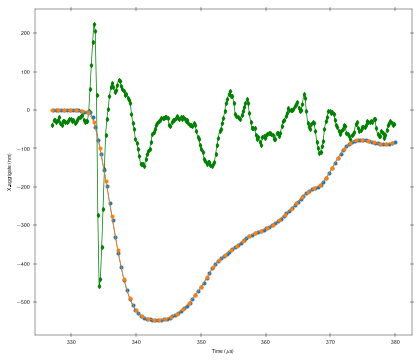

In [1253]:
tmin= 327e-6
tmax = 380e-6
fig, ax = plt.subplots(1,1, figsize=(2*3.375, 2*3))
Cnbd = load_collection(fname_nbd, "X", None, 
                          differentiate=False, cutoff=2000e3, Npts="cutoff", shift=0, invert=True)
Cnbd.apply("calibrate", cal=100*C0.cal, inplace=True)
Cnbd.aggrigate()
Cnbd.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit="nm", tunit="us", zorder=0,
                marker="d", ms=3, c="g", lw=0.75, label=r"500 $\times$NO microsphere")


for BW in [500e3, 1000e3][::-1]:
    Cbd_fl = load_collection(fname_fl, "X", None, 
                          differentiate=False, cutoff=BW, Npts="cutoff", 
                          shift=0, invert=False)
    Cbd_fl.apply("calibrate", cal=C0.cal, inplace=True)
    Cbd_fl.aggrigate()
    Cbd_fl.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit="nm", tunit="us", label=f"BW={BW/1e3} kHz",
                 marker="o", ms=3, lw=0.75)


0 0 0
0 1 3
3 0 4
3 1 7
6 0 8
6 1 11
9 0 12
9 1 15
2.2000000000000004e-07
[3.5        3.86363636 4.22727273 4.59090909 4.95454545 5.31818182
 5.68181818 6.04545455 6.40909091 6.77272727 7.13636364 7.5       ] [0.24063616 0.30724479 0.27463896 0.28375736 0.29761048 0.32065708
 0.27233832 0.28755271 0.3403678  0.29958798 0.30787426 0.27350876]
349.2389568059893 0.7829815684950586
-1.1155757738930738 0.35719226871881177
8.000000000000007e-07
[3.5        3.86363636 4.22727273 4.59090909 4.95454545 5.31818182
 5.68181818 6.04545455 6.40909091 6.77272727 7.13636364 7.5       ] [ 3.09321839  4.86018271  4.74526122  6.79408684  6.95630247 10.32122783
  9.93514972 13.05937211 11.51767754 12.44794859 14.03621373 13.57120717]
358.07021482203936 23.341239341773704
-0.9296658587124339 8.12480447314919


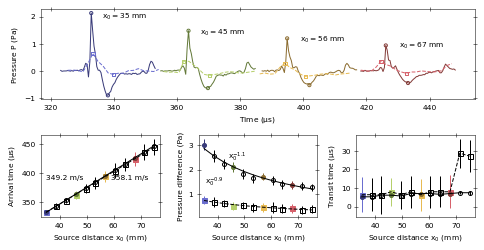

2.2000000000000004e-07
[3.5        3.86363636 4.22727273 4.59090909 4.95454545 5.31818182
 5.68181818 6.04545455 6.40909091 6.77272727 7.13636364 7.5       ] [0.28375736 0.23999167 0.29265789 0.24698858 0.31100251 0.26238171
 0.25029774 0.28569522 0.30733929 0.28916404 0.25652415 0.264     ]
349.8727456948158 0.7555418688402697
-1.4929382375351774 0.3471703867586901
8.000000000000007e-07
[3.5        3.86363636 4.22727273 4.59090909 4.95454545 5.31818182
 5.68181818 6.04545455 6.40909091 6.77272727 7.13636364 7.5       ] [0.8        0.87269697 1.05830052 1.12853888 2.11533071 2.96647939
 3.61242301 3.86379296 5.0886792  5.04484846 7.21553879 6.84005146]
362.6674612790882 8.28123595447455
-1.0614391723439998 2.6377121755390514


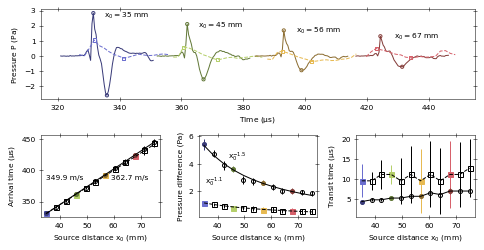

2.2000000000000004e-07
[3.5        3.86363636 4.22727273 4.59090909 4.95454545 5.31818182
 5.68181818 6.04545455 6.40909091 6.77272727 7.13636364 7.5       ] [0.22       0.31112698 0.30305749 0.26778618 0.243555   0.30607685
 0.22846129 0.25656188 0.29708962 0.31062878 0.23245163 0.22431371]
350.36124920239496 0.7032311111866407
-1.5267018434464976 0.3268342064197673
8.000000000000007e-07
[3.5        3.86363636 4.22727273 4.59090909 4.95454545 5.31818182
 5.68181818 6.04545455 6.40909091 6.77272727 7.13636364 7.5       ] [1.12       1.12955921 1.10851252 3.63295142 1.12410676 3.10247385
 2.38265734 1.26024759 3.96383653 2.7340812  1.26551808 1.16481758]
360.025237722565 3.7927097661734384
-0.8361631430730044 1.5968921580120332


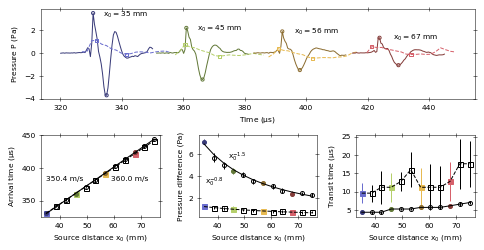

In [259]:
import matplotlib.gridspec as gridspec

t0 = 330e-6
c0 = 351
Dt = 25e-6
factor = 0.0

Nshots = 100
shots = list(range(Nshots)) + ["avg"]


plot_posis = [0,3,6,9]
plot_shotis = [Nshots]


pulse_points = np.zeros((2, len(enes), len(poss), len(shots), 5, 2))


color_set =  plt.cm.tab20b(np.arange(4*len(plot_posis)))
colors = {}
for ppi, plot_posi in enumerate(plot_posis):
    for Ci in range(2):
        print(plot_posi, Ci, ppi*4 + Ci*3)
        colors[plot_posi+Ci] = color_set[ppi*4 + Ci*2]

for enei, ene in enumerate(enes[:]):
    fig = plt.figure(tight_layout=True, figsize=(2*3.375, 3.5))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1.1, 1])
    ax = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[1, 2])
    axs = [ax1, ax2, ax3]
    for shoti, shotnum in enumerate(shots):
        for posi, pos in enumerate(poss):
            Cbd2 = Cbd2s[enei, posi]
            Cfl = Cfls[enei, posi]
            Cbd2.aggrigate(collection_slice=25)
            Cfl.apply("detrend", mode="constant", inplace=True)
            Cfl.aggrigate(collection_slice=25)
            for Ci, C in enumerate((Cbd2, Cfl)):
                if Ci == 0:
                    marker = "o"
                    ls = "-"
                if Ci == 1:
                    marker = "s"
                    ls = "--"
                if shotnum == "avg":
                    D = C.agg
                    label = r"$x_0 = {%s}~{\rm mm}$"%int((3.5+pos)*10)
                else:
                    try:
                        D = C.collection[shotnum]
                    except: continue
                    alpha = 1
                # initial window
                tmin = t0 + pos*1e-2/c0 - Dt
                tmax = t0 + pos*1e-2/c0 + Dt
                ts, xs = D.time_gate(tmin, tmax)
                # refine window
                ttrough = ts[np.argmin(xs)]
                tmin = ttrough - 25e-6
                tmax = ttrough + 25e-6
                ts, xs = D.time_gate(tmin, tmax)
                try:
                    tpoints, xpoints = find_pulse_points(D, tmin=tmin, tmax=tmax, factor=factor, nozeros=True)
                    pulse_points[Ci, enei, posi, shoti, :, 0] = tpoints
                    pulse_points[Ci, enei, posi, shoti, :, 1] = xpoints
                    points_found = True
                except:
                    points_found = False

                    
                
            
                if shoti in plot_shotis:
                    if posi in plot_posis:
                        c = colors[posi + Ci]
                        D.plot(ax=ax, tmin=ttrough-15e-6, tmax=ttrough+15e-6,
                           tunit="us", unit="Pa", zorder=posi, color=c, alpha=alpha, ls=ls, label=label, lw=1)
                        if Ci == 0:
                            ax.text(tpoints[1]*1e6*(1+0.01), xpoints[1]*(1-0.1), label)
                        if points_found:
                            for pi, (t, x) in enumerate(zip(tpoints, xpoints)):
                                if pi in (1,3):
                                    ax.scatter(t*1e6, x, marker=marker, ec=c, fc="none", lw=1, s=10, zorder=100)
                        
    if points_found:
        shoti = plot_shotis[-1]
        for Ci, C in enumerate([Cbd, Cfl]):
            if Ci == 0:
                marker = "o"
                ls="-"
                label="microsphere"
            if Ci == 1:
                marker = "s"
                ls="--"
                label="microphone" 
            abs_pos = poss + 3.5
            tpeak = pulse_points[Ci, enei, :, shoti, 1, 0] * 1e6
            dtpeak = np.std(pulse_points[Ci, enei, :, :-1, 1, 0] * 1e6, axis=1)
            print((1/(2*C.r)))
            dtpeak = np.sqrt(dtpeak**2 + (1e6 * 1 /(2*C.r))**2) 
            DeltaP = pulse_points[Ci, enei, :, shoti, 1, 1] - pulse_points[Ci, enei, :, shoti, 3, 1]
            dDeltaP = np.std(pulse_points[Ci, enei, :, :-1, 1, 1] - pulse_points[Ci, enei, :, :-1, 3, 1], axis=1)
            trise = (pulse_points[Ci, enei, :, shoti, 1, 0] - pulse_points[Ci, enei, :, shoti, 0, 0]) * 1e6
            dtrise = np.std(pulse_points[Ci, enei, :, :-1, 1, 0] - pulse_points[Ci, enei, :, :-1, 0, 0]) * 1e6
            dtrise = np.sqrt(dtrise**2 + (1e6 * 1 /(2*C.r))**2) 
            Deltat = (pulse_points[Ci, enei, :, shoti, 3, 0] - pulse_points[Ci, enei, :, shoti, 1, 0]) * 1e6
            dDeltat = np.std(pulse_points[Ci, enei, :, :-1, 3, 0] - pulse_points[Ci, enei, :, :-1, 1, 0], axis=1) * 1e6
            dDeltat = np.sqrt(dDeltat**2 + (1e6 * 1 /(2*C.r))**2) 
            ttransit = (pulse_points[Ci, enei, :, shoti, 2, 0] - pulse_points[Ci, enei, :, shoti, 1, 0]) * 1e6
            dttransit = np.std(pulse_points[Ci, enei, :, :-1, 2, 0] - pulse_points[Ci, enei, :, :-1, 1, 0], axis=1) * 1e6
            dttransit = np.sqrt(dttransit**2 + (1e6 * 1 /(2*C.r))**2) 
            popt1, pcov1 = curve_fit(line, abs_pos, tpeak, p0=[(350*1e2/1e6), tpeak[0]], sigma=dtpeak, absolute_sigma=True,
                                     bounds=[(0, 0), (np.inf, np.inf)])
            perr1 = np.sqrt(np.diag(pcov1))
            popt2, pcov2 = curve_fit(powerlaw, abs_pos, DeltaP, p0=[10000, -3], sigma=dDeltaP, absolute_sigma=True,
                                     bounds=[(-np.inf, -np.inf), (np.inf, np.inf)])
            perr2 = np.sqrt(np.diag(pcov1))
            
            speed = popt1[0] * 1e6 / 1e2
            dspeed = perr1[0]  * 1e6 / 1e2
            exponent = popt2[1]
            dexponent = perr2[1]
            print(abs_pos, dtpeak)
            print(speed, dspeed)
            print(exponent, dexponent)
            
            axs[0].plot(abs_pos*10, line(abs_pos, *popt1), c="k", ls=ls, lw=1)
            axs[1].plot(abs_pos*10, powerlaw(abs_pos, *popt2), c="k", ls=ls, lw=1)
            axs[2].plot(abs_pos*10, Deltat, c="k", mec="k", mfc="none", ls=ls, lw=1)
            for posi, (pos, tpk, dtpk, DP, dDP, tt, dtt) in enumerate(zip(abs_pos, tpeak, dtpeak, DeltaP, dDeltaP, Deltat, dDeltat)):
                if posi in plot_posis:
                    c = colors[posi + Ci]
                    fc = c
                else:
                    c = "k"
                    fc = "none"
                axs[0].errorbar(pos*10, tpk, yerr=dtpk, mec=c, mfc=fc, ecolor=c, lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
                axs[1].errorbar(pos*10, DP, yerr=dDP, mec=c, mfc=fc, ecolor=c, lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
                axs[2].errorbar(pos*10, tt, yerr=dtt, mec=c, mfc=fc, ecolor=c, lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
            axs[0].text(0.04+Ci*0.55, 0.45, f"{round(speed,1)} m/s", transform=axs[0].transAxes)
            axs[1].text(0.05+(1-Ci)*0.2, 0.4+(1-Ci)*0.3, r"$x_0^{%s}$"%round(exponent, 1), transform=axs[1].transAxes)
    ax.set_ylabel("Pressure $P$ (Pa)")
    axs[0].set_ylabel(r"Arrival time $({\rm \mu s})$")
    axs[1].set_ylabel(r"Pressure difference (Pa)")
    axs[2].set_ylabel( r"Transit time $({\rm \mu s})$")
    for ax0 in axs:
        ax0.set_xlabel("Source distance $x_0$ (mm)")
    plt.savefig(f"figures/laser-pos-scan_ene{ene}.pdf")
    plt.show()

# No bead

In [1113]:
fnames

['/data/brownian/20220707/bead1/nobead_phone_ene-scan_100us-delay/iter_0.tdms',
 '/data/brownian/20220707/bead1/nobead_phone_ene-scan_100us-delay/iter_1.tdms',
 '/data/brownian/20220707/bead1/nobead_phone_ene-scan_100us-delay/iter_2.tdms',
 '/data/brownian/20220707/bead1/nobead_phone_ene-scan_100us-delay/iter_3.tdms',
 '/data/brownian/20220707/bead1/nobead_phone_ene-scan_100us-delay/iter_10.tdms']

In [1194]:
fnames_nbd = sort_fnames(find_files(experiment_ders[4]))
musphere_response = make_musphere_response(C0, response="bassetbound", impedance=None, r0=0)
bd_cutoff = 500e3
Cnbds = []
Cphs_nbd = []
for fname in fnames_nbd:
    Cnbd = load_collection(fname, "X", None, 
                  differentiate=False, cutoff=bd_cutoff, Npts="cutoff", shift=0, invert=True)
    print(Cnbd.pos, Cfl.pos, Cph.pos)
    print(Cnbd.ene, Cfl.ene, Cph.ene)
    print()
    Cnbd.apply("calibrate", cal=30, inplace=True)
    Cph_nbd = load_collection(fname, "Y", None, 
                  differentiate=False, cutoff=200e3, Npts=int(25e6/(2*200e3)), shift=25e-6, invert=False)
    Cnbd.aggrigate()
    Cph_nbd.aggrigate()
    Cphs_nbd.append(Cph_nbd)
    Cnbds.append(Cnbd)


0.0 1.0909090909090908 1.0909090909090908
12.0 14.0 14.0

0.0 1.0909090909090908 1.0909090909090908
14.0 14.0 14.0

0.0 1.0909090909090908 1.0909090909090908
16.0 14.0 14.0

0.0 1.0909090909090908 1.0909090909090908
18.0 14.0 14.0

3.6363636363636362 1.0909090909090908 1.0909090909090908
12.0 14.0 14.0



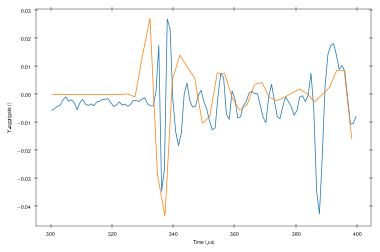

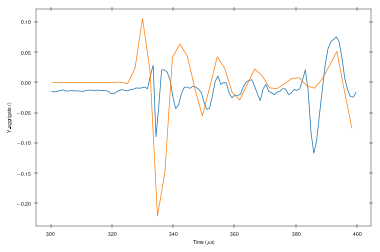

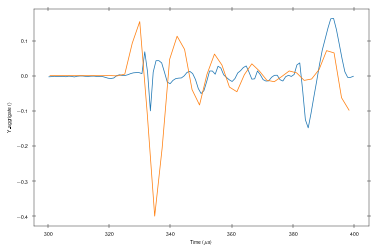

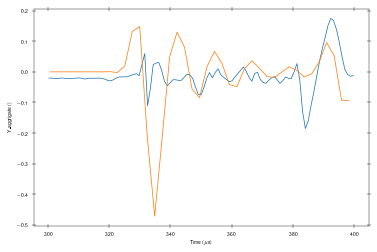

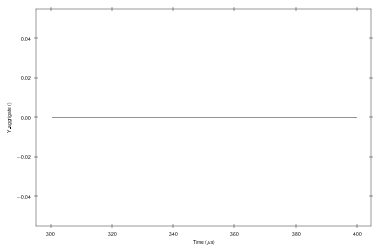

In [1121]:
tmin=300e-6
tmax=400e-6
for Cnbd, Cph in zip(Cnbds, Cphs_nbd):
    fig, ax = plt.subplots(1,1)
    for C in [Cnbd, Cph]:
        D = C.agg
        D.plot(ax=ax, tmin=tmin, tmax=tmax,
                       tunit="us", unit=1, lw=0.75)